# FX Volatility Model Comparison

This notebook demonstrates how to access and use the functionalities of **FX Volatility Surfaces** within the **LSEG Financial Analytics SDK**. 

**You will be able to:**
- Calculate multiple volatility surfaces in a single request
- Compare different volatility models (SVI vs SABR)
- Visualize differences between model outputs

## Imports

Import the following necessary modules:
- `lseg_analytics.pricing.market_data.fx_volatility` - for FX volatility surfaces construction

This notebook uses external libraries **pandas, IPython, matplotlib**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.market_data import fx_volatility as fxv

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import copy
from IPython.display import display

## Data Preparation

Volatility surface preparation follows a structured 3-step process:

**Prerequisites:** 
- Valid LSEG credentials and market data entitlements

**Process Overview:**
1. **Surface Definition** - Specify the underlying instrument (fx pair)
2. **Surface Parameters** - Configure volatility model and calculation settings
3. **Request Creation** - Combine definition and parameters into a request object  

Each step builds upon the previous, creating a complete request specification for the volatility surface engine.

### FX Surface Parameters with SVI

In [2]:
print("Step 1: Creating Surface Definition...")

currencyPair = "EURUSD"

# Create surface definition object
surface_definition = fxv.FxVolatilitySurfaceDefinition(
        instrument_code = currencyPair
        )
print(f"   ✓ Instrument: {surface_definition.instrument_code}")

print("Step 2: Configuring Surface Parameters...")
surface_parameters_svi = fxv.FxVolatilityPricingParameters(
        calculation_date = dt.datetime.strptime("2025-01-18", "%Y-%m-%d"),
        volatility_model = fxv.CurvesAndSurfacesVolatilityModelEnum.SVI,  # Options: SVI, SABR, TWIN_LOGNORMAL
        x_axis = fxv.XAxisEnum.DELTA,                                     # Options: DATE, DELTA, MONEYNESS, STRIKE, TENOR
        y_axis = fxv.YAxisEnum.TENOR                                      # Options: same as X-axis
    )
print(f"   ✓ Surface Parameters: {surface_parameters_svi}")


print("Step 3: Create request item...")
# Create the main request object  with basic configuration
request_item_svi = fxv.FxVolatilitySurfaceRequestItem(
        surface_tag = f"{currencyPair}_SVI_Volsurface",
        underlying_definition = surface_definition,
        surface_parameters = surface_parameters_svi,
        underlying_type = fxv.CurvesAndSurfacesUnderlyingTypeEnum.FX,
        surface_layout = fxv.SurfaceOutput(
            format = fxv.FormatEnum.MATRIX,  # Options: LIST, MATRIX
        )
    )
print(f"   ✓ Request Item: {request_item_svi}")

Step 1: Creating Surface Definition...
   ✓ Instrument: EURUSD
Step 2: Configuring Surface Parameters...
   ✓ Surface Parameters: {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SVI', 'xAxis': 'Delta', 'yAxis': 'Tenor'}
Step 3: Create request item...
   ✓ Request Item: {'surfaceTag': 'EURUSD_SVI_Volsurface', 'underlyingDefinition': {'instrumentCode': 'EURUSD'}, 'surfaceParameters': {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SVI', 'xAxis': 'Delta', 'yAxis': 'Tenor'}, 'underlyingType': 'Fx', 'surfaceLayout': {'format': 'Matrix'}}


### FX Surface Parameters with SABR


In [3]:
# Changing the model and keeping the same other parameters
surface_parameters_sabr = copy.deepcopy(surface_parameters_svi)
surface_parameters_sabr.volatility_model = fxv.CurvesAndSurfacesVolatilityModelEnum.SABR

# Create another request Item for SABR
request_item_sabr = copy.deepcopy(request_item_svi)
request_item_sabr.surface_tag = f"{currencyPair}_SABR_Volsurface"
request_item_sabr.surface_parameters = surface_parameters_sabr
print(f"   ✓ Request Item: {request_item_sabr}")

   ✓ Request Item: {'surfaceTag': 'EURUSD_SABR_Volsurface', 'underlyingDefinition': {'instrumentCode': 'EURUSD'}, 'surfaceParameters': {'calculationDate': '2025-01-18T00:00:00Z', 'volatilityModel': 'SABR', 'xAxis': 'Delta', 'yAxis': 'Tenor'}, 'underlyingType': 'Fx', 'surfaceLayout': {'format': 'Matrix'}}


In [4]:
# Execute the calculation using the calculate function
# The 'universe' parameter accepts a list of request items for batch processing
try:
    response = fxv.calculate(universe=[request_item_svi, request_item_sabr])

    # Display response structure information
    surface_data = response['data'][0]
    if 'surface' in surface_data:
        print(f"   Calculation successful!")
        print(f"   Surface data points available: {len(surface_data['surface'])}")
    else:
        print("   No surface data found in response")
    
except Exception as e:
    print(f"   Calculation failed: {str(e)}")
    raise

   Calculation successful!
   Surface data points available: 18


## Results Display

In [5]:
# Display the raw surface data
print(response['data'][0]['surfaceTag'])
print(response['data'][1]['surfaceTag'])

EURUSD_SVI_Volsurface
EURUSD_SABR_Volsurface


In [6]:
# Create DataFrame for SVI surface
vol_surface_svi = response['data'][0]['surface']
expiries = vol_surface_svi[0][1:]
deltas = []
values = []
for row in vol_surface_svi[1:]:
    deltas.append(row[0])
    values.append(row[1:])

surface_df_svi = pd.DataFrame(values, index=deltas, columns=expiries).T.astype(float)

# Create DataFrame for SABR surface
vol_surface_sabr = response['data'][1]['surface']
values = []
for row in vol_surface_sabr[1:]:
    values.append(row[1:])

surface_df_sabr = pd.DataFrame(values, index=deltas, columns=expiries).T.astype(float)

# DataFrame of Differences
differences_df = surface_df_svi - surface_df_sabr
display(differences_df.round(2))

,-0.1,-0.15,-0.2,-0.25,-0.3,-0.35,-0.4,-0.45,ATM,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1
ON,-0.05,0.01,0.03,0.04,0.04,0.03,0.01,0.00,-0.0,0.01,0.02,0.03,0.04,0.04,0.03,0.00,-0.06
SW,-0.02,0.02,0.02,0.02,0.02,0.01,0.00,-0.00,-0.0,0.00,0.01,0.02,0.02,0.03,0.03,0.01,-0.04
2W,0.02,0.01,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.0,0.00,0.01,0.01,0.01,0.01,0.01,0.00,-0.02
1M,-0.01,0.01,0.01,0.01,0.01,0.00,0.00,-0.00,-0.0,0.00,0.01,0.01,0.01,0.02,0.02,0.01,-0.02
2M,-0.02,0.02,0.03,0.02,0.02,0.01,0.00,-0.00,-0.0,0.00,0.01,0.02,0.02,0.03,0.03,0.01,-0.04
3M,-0.10,-0.01,0.03,0.05,0.05,0.04,0.03,0.01,-0.0,-0.01,-0.01,-0.01,0.01,0.02,0.03,0.03,-0.01
6M,-0.11,-0.01,0.04,0.05,0.05,0.04,0.03,0.01,-0.0,-0.01,-0.01,-0.01,0.00,0.02,0.03,0.02,-0.02
9M,-0.04,0.04,0.07,0.06,0.05,0.03,0.02,0.01,-0.0,-0.00,0.00,0.01,0.02,0.03,0.03,0.00,-0.07
1Y,-0.05,0.03,0.05,0.05,0.04,0.03,0.02,0.01,0.0,-0.00,-0.00,0.00,0.01,0.01,0.02,0.00,-0.04
2Y,0.02,0.05,0.05,0.04,0.02,0.01,0.00,-0.00,0.0,0.00,0.01,0.02,0.02,0.03,0.02,-0.00,-0.07


### Plotting Volatility Smile for "2Y" Expiry

Text(0, 0.5, 'Volatility')

<Figure size 640x480 with 0 Axes>

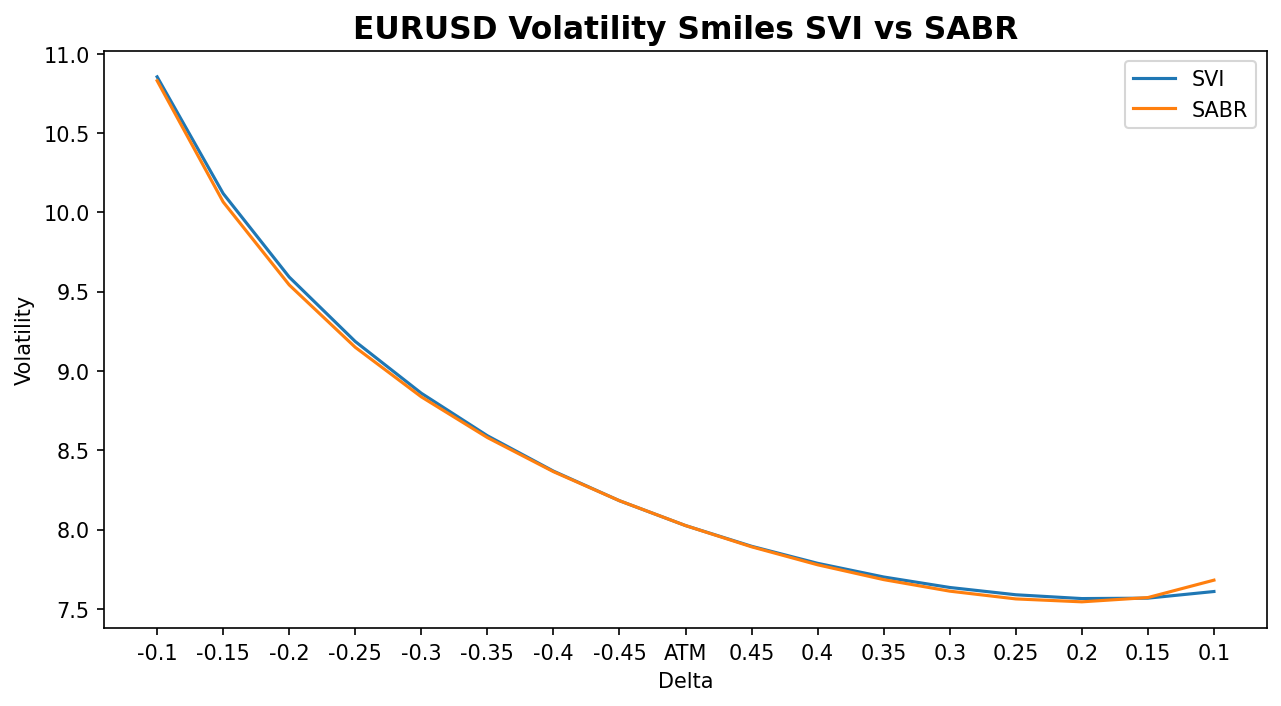

In [7]:
plt.figure()
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(surface_df_svi.columns.map(str), surface_df_svi.T["2Y"], label = "SVI")
plt.plot(surface_df_sabr.columns.map(str), surface_df_sabr.T["2Y"], label = "SABR")
plt.title(f"{currencyPair} Volatility Smiles SVI vs SABR", fontdict={'fontweight':'bold','fontsize':15})
plt.legend(loc='upper right')
plt.xlabel('Delta')
plt.ylabel('Volatility')